### First set number of cores on machine to use and SSID number to analyse, then run all

In [2]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 20392040 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [4]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 5.77 s


In [5]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(7444, 12)

time: 108 ms


In [6]:
ssid_df.memory_usage(deep=True)

Index                   80
Day                 478090
DestStopID           59552
HourFrame            59552
JourneyPatternID    415246
Rain                 59552
SSID                120336
SchoolHoliday         7444
SourceStopID         59552
TimeFrame           498748
TravelTime           59552
VehicleJourneyID     59552
WindSpeed            59552
dtype: int64

time: 7 ms


In [7]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 8 unique JPIDs traversing this segment, over the course of 7444 observations.
time: 3 ms


In [8]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 5 ms


### 1b Adding extra features and altering/dropping existing ones

In [9]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 10 ms


In [10]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(7444, 14)

time: 217 ms


In [11]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x00000000085694A8>> (for post_run_cell):


AssertionError: 

In [12]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [13]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 12 ms


In [14]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 4 ms


In [15]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,21,0.000000,16.0,42,0,0,Tuesday,22
1,23,0.000000,15.5,42,0,0,Tuesday,23
2,21,0.033333,14.5,42,0,0,Tuesday,7
3,41,0.000000,16.0,42,0,0,Tuesday,22
4,19,0.000000,15.5,42,0,0,Wednesday,22
5,41,0.033333,16.5,42,0,0,Wednesday,23
6,21,0.000000,14.0,42,0,0,Wednesday,7
7,21,0.000000,13.5,42,0,0,Thursday,6
8,21,0.000000,11.0,42,0,0,Thursday,22
9,41,0.000000,13.0,42,0,0,Thursday,23


time: 25 ms


In [16]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 31 ms


In [17]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 8 ms


In [18]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,21,0.000000,16.0,42,0,Tuesday,22
1,23,0.000000,15.5,42,0,Tuesday,23
2,21,0.033333,14.5,42,0,Tuesday,7
3,41,0.000000,16.0,42,0,Tuesday,22
4,19,0.000000,15.5,42,0,Wednesday,22
5,41,0.033333,16.5,42,0,Wednesday,23
6,21,0.000000,14.0,42,0,Wednesday,7
7,21,0.000000,13.5,42,0,Thursday,6
8,21,0.000000,11.0,42,0,Thursday,22
9,41,0.000000,13.0,42,0,Thursday,23


time: 24 ms


In [19]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 41 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

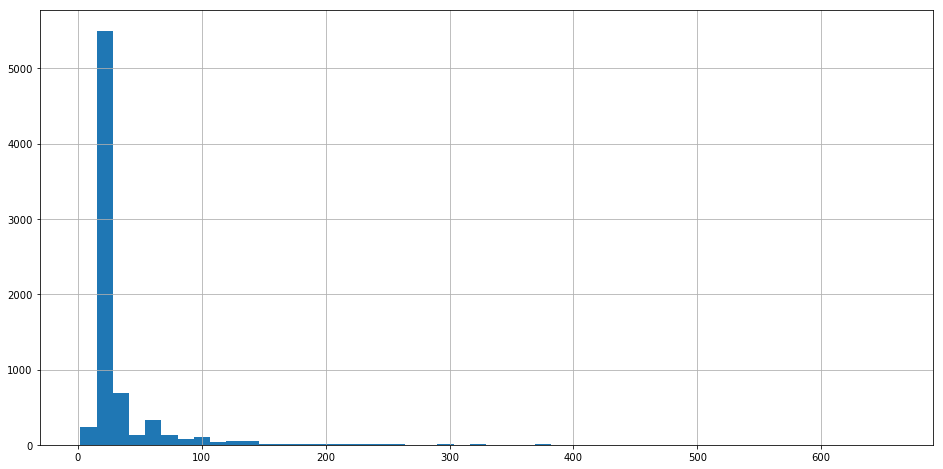

time: 223 ms


In [20]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

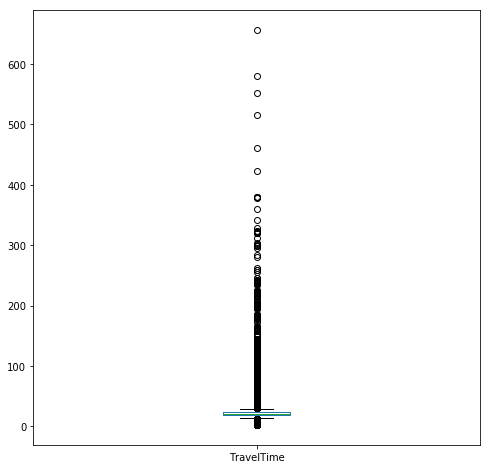

time: 158 ms


In [21]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [22]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    7444.000000
mean       32.015717
std        36.155138
min         2.000000
25%        19.000000
50%        21.000000
75%        23.000000
max       657.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [23]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

16.3610330511
time: 68 ms


In [24]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 2022 outliers dropped.
time: 12 ms


In [25]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 40 ms


In [26]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    5422.000000
mean       20.277204
std         1.935806
min        17.000000
25%        19.000000
50%        20.000000
75%        21.000000
max        31.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

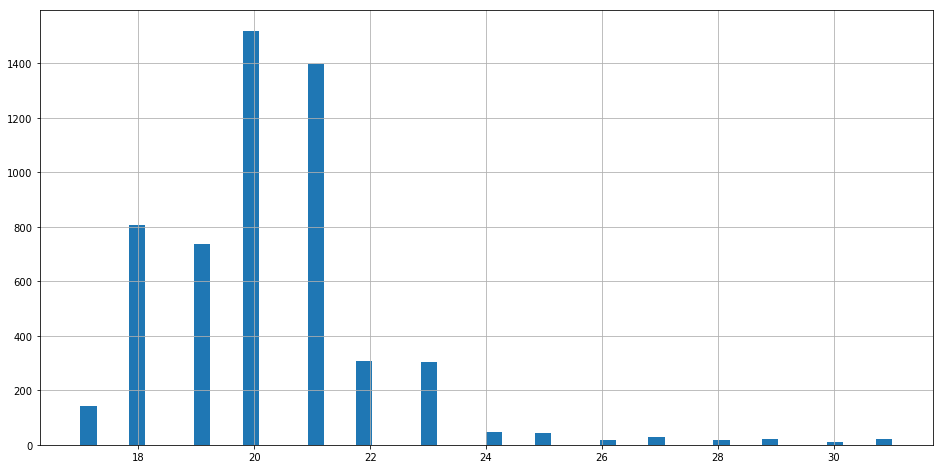

time: 217 ms


In [27]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

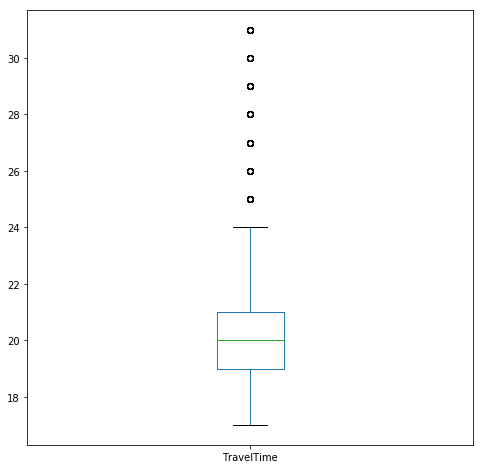

time: 144 ms


In [28]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

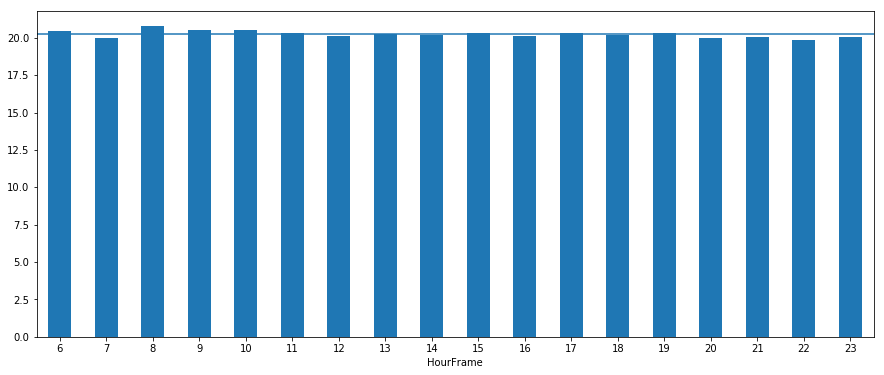

time: 196 ms


In [29]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

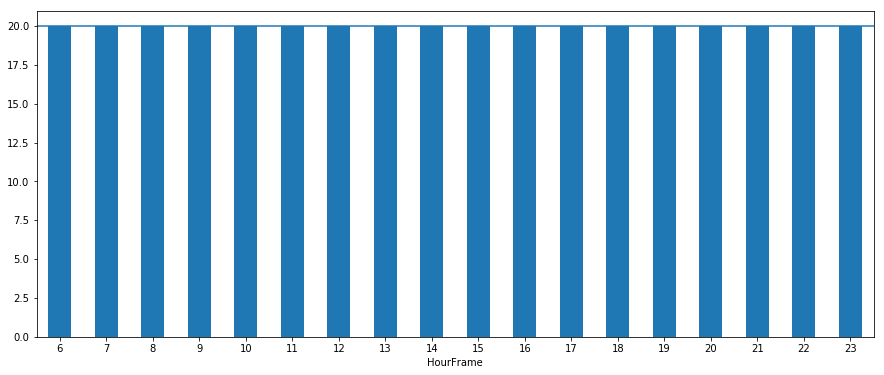

time: 192 ms


In [30]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

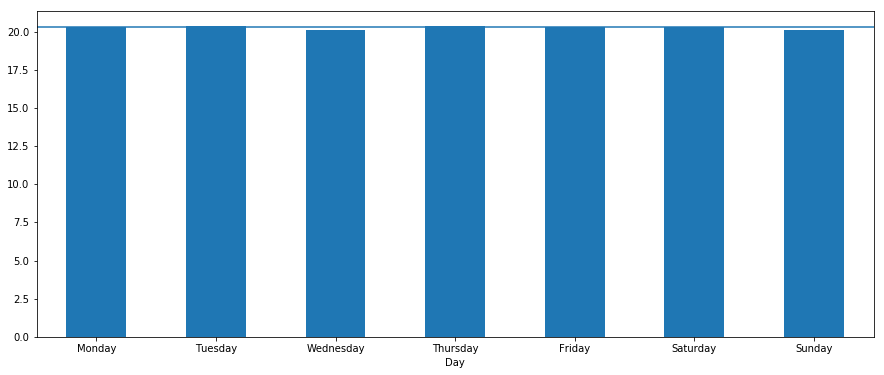

time: 154 ms


In [31]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

In [ ]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

In [ ]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

In [ ]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [ ]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

In [ ]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

In [ ]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

In [ ]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [ ]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

In [ ]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

In [ ]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

In [ ]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [ ]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

In [ ]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

In [ ]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

In [ ]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

In [ ]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

In [ ]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [ ]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

In [ ]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

In [ ]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

### 3di Gradient Boosting Regression model - training - default parameters

In [ ]:
gbr = GBR()
gbr.fit(X_train, y_train)

In [ ]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

In [ ]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

In [ ]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

In [ ]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

### 3dii Gradient Boosting Regression model - - testing - default parameters

In [ ]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

In [ ]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

In [ ]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

### 3ei Random Forest Regression model (all default) - training - default parameters

In [ ]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

In [ ]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

In [ ]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

In [ ]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

In [ ]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

### 3eii Random Forest Regression model (all default) - testing - default parameters

In [ ]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

In [ ]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

In [ ]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

## 4 Both Tree models - parameter tuning with RandomizedSearchCV

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [ ]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

In [ ]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

In [ ]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

In [ ]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

In [ ]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

In [ ]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

### 4b Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [ ]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(2, 100)}

In [ ]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

In [ ]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

In [ ]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

In [ ]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

In [ ]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")